In [1]:
import pandas as pd
from urllib.request import urlopen  
import os.path as osp
import os
import logging
import zipfile
from glob import glob


## Helpers

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')       
    output.write(url.read())
    output.close()  
    
def extract_file(archive_path, target_dir):
    zip_file = zipfile.ZipFile(archive_path, 'r')
    zip_file.extractall(target_dir)
    zip_file.close()

## Download the dataset

In [3]:
BASE_URL = 'http://tennis-data.co.uk'
DATA_DIR = "tennis_data"
ATP_DIR = './{}/ATP'.format(DATA_DIR)

ATP_URLS = [BASE_URL + "/%i/%i.zip" % (i,i) for i in range(2000,2019)]

os.makedirs(osp.join(ATP_DIR, 'archives'), exist_ok=True)

for files, directory in ((ATP_URLS,ATP_DIR),(ATP_URLS,ATP_DIR)):
    for dl_path in files:
        logging.info("downloading & extracting file %s", dl_path)
        archive_path = osp.join(directory, 'archives', osp.basename(dl_path))
        download_file(dl_path, archive_path)
        extract_file(archive_path, directory)
    
ATP_FILES = sorted(glob("%s/*.xls*" % ATP_DIR))

df_atp = pd.concat([pd.read_excel(f) for f in ATP_FILES], ignore_index=True)

logging.info("%i matches ATP in df_atp", df_atp.shape[0])


# Exploratory Data Analysis through questions  
In this section, we will try to ask and respond to some questions to get used to the problem and gain some insights.

In [4]:
import numpy as np
import re    #Regular Expression module for string manipulation
import plotnine as pln #Plotting library (implementation of R's ggplot2)
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

****************************

# Data Preparation
## Data Splitting

We start first by selecting the rows we're going to use, they belong to 4 categories :  
1 - Location and organisation related features ( Tournament, Series, Date, Round)  
2 - Game field related data (Surface, Court)  
3 - Players' performances (LPts, WPts, WRank, LRank)  
4 - Average betting data (AvgW, AvgL)  

In [5]:
usedColumns = ['Best of',
'Court',
'Date',
'LPts',
 'LRank',
'Loser',
 'Round',
 'Series',
 'Surface',
 'Tournament',
'WPts',
 'WRank',
 'Winner','AvgW','AvgL','MaxW','MaxL']

In [6]:
#Preparing rows indexes for splitting (Train-Test)
gTest = lambda x: x.year == 2017
gTrain = lambda x: x.year < 2017
testInd = df_atp['Date'].apply(gTest)
trainInd = df_atp['Date'].apply(gTrain)

In [7]:
#Splitting data (Train - Test)
df_atp_Train = df_atp.loc[trainInd, usedColumns].copy()
df_atp_Test = df_atp.loc[testInd, usedColumns].copy()
print("Shape of atp data : a)Train = "+str(df_atp_Train.shape)+ " ; b)Test = "+str(df_atp_Test.shape))

Shape of atp data : a)Train = (47028, 17) ; b)Test = (2635, 17)


In [8]:
df_atp_Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47028 entries, 0 to 47027
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Best of     47028 non-null  int64         
 1   Court       47028 non-null  object        
 2   Date        47028 non-null  datetime64[ns]
 3   LPts        30772 non-null  float64       
 4   LRank       46957 non-null  object        
 5   Loser       47028 non-null  object        
 6   Round       47028 non-null  object        
 7   Series      47028 non-null  object        
 8   Surface     47028 non-null  object        
 9   Tournament  47028 non-null  object        
 10  WPts        30824 non-null  float64       
 11  WRank       47013 non-null  object        
 12  Winner      47028 non-null  object        
 13  AvgW        17479 non-null  float64       
 14  AvgL        17479 non-null  float64       
 15  MaxW        17479 non-null  float64       
 16  MaxL        17479 non-

#  Data Preprocessing 

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

## 1 - Missing Values Imputation
### 1.1 - Overview of data missing values

We start by examining columns with missing values. The columns with the most NA's are those Points related.

A quick exploration of the unique values in 'WRank' and 'LRank' shows that there are 3 types of values : **Numerical, 'NR', and nan**. We first turn 'NR' (*Not recognized*) to np.NaN to deal with it as a missing value.

In [10]:
naRankIndW = df_atp_Train.loc[:,'WRank'].apply(lambda x: x=='NR') 
naRankIndL = df_atp_Train.loc[:,'LRank'].apply(lambda x: x=='NR')
df_atp_Train.loc[naRankIndW,'WRank'] = np.NaN
df_atp_Train.loc[naRankIndL,'LRank'] = np.NaN

In [11]:
print("Number of missing values in WRank column : " + str(np.sum(df_atp_Train.WRank.isna())))
print("Number of missing values in LRank column : " + str(np.sum(df_atp_Train.LRank.isna())))

Number of missing values in WRank column : 16
Number of missing values in LRank column : 98


Fortunately, 'Date' column is clear with no missing values.

In [12]:
print("Number of missing values in Date column : " + str(np.sum(df_atp_Train.Date.isna())))

Number of missing values in Date column : 0


### 1.2 - Imputation of Rank-related missing values

We start by imputing the Rank-related missing values since they are less frequent, using a per-player linear regression model modeling Rank = f(Date). We'll use these values later to impute Points-related values since there is a large correlation between players' rankings and points (Ranking is by definition based on Points).  
To do so, we distinguish two separate cases :  
- **Players having some non-NA (date,rank) observations** : in this case, we will fit a simple linear regression model to interpolate the missing ranks.  
- **Players having no recorded (date,rank) observation** : in this case, we will impute the median value of winners' ranks and losers' rank for winner and loser cases respectively.  

We'll try to see some per-player Date - Rank relationship.

In [13]:
myPlayer = 'Agassi A.'

In [14]:
winData = df_atp_Train.loc[df_atp_Train.Winner==myPlayer,['Date', 'WRank']]
loseData = df_atp_Train.loc[df_atp_Train.Loser==myPlayer,['Date','LRank']]
    
RankData = pd.DataFrame({'Date':pd.concat([winData.Date, loseData.Date], axis=0), 
                             'Rank':pd.concat([winData.WRank, loseData.LRank], axis=0)})
RankData.sort_index(axis=0, inplace=True)

In [15]:
RankData['Date'] = RankData['Date'].apply(lambda x : x.year +(x.month-1)/12)

In [16]:
RankData.dropna(inplace=True)

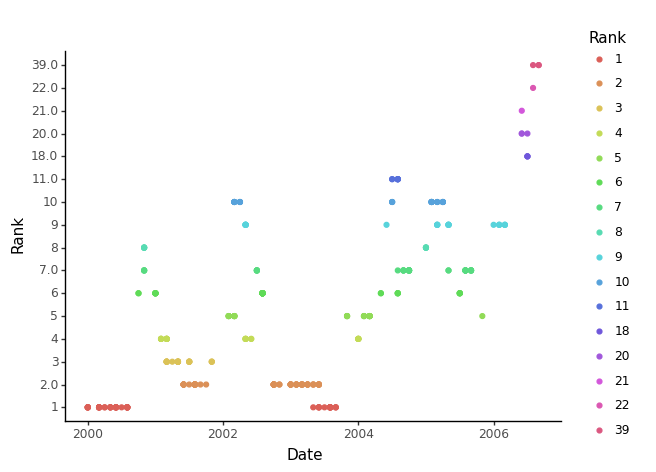

<ggplot: (-9223363272427866024)>

In [17]:
#RankData
pln.ggplot(RankData, pln.aes(x='Date', y='Rank'))+pln.geom_point(pln.aes(colour='Rank'))+pln.theme_classic() 

The shape of the time serie varies of course from a player to another one. One simple way to model this relationship is using a polynomial regression with a degree depending on the size of available data of the given player.

In [18]:
RankData["Rank"] = RankData["Rank"].astype(float)
weights_date_rank = np.polyfit(RankData.Date, RankData.Rank, 3)
model_date_rank = np.poly1d(weights_date_rank)
preds_rank = np.round(model_date_rank(RankData.Date))
preds_rank[preds_rank<1] = 1

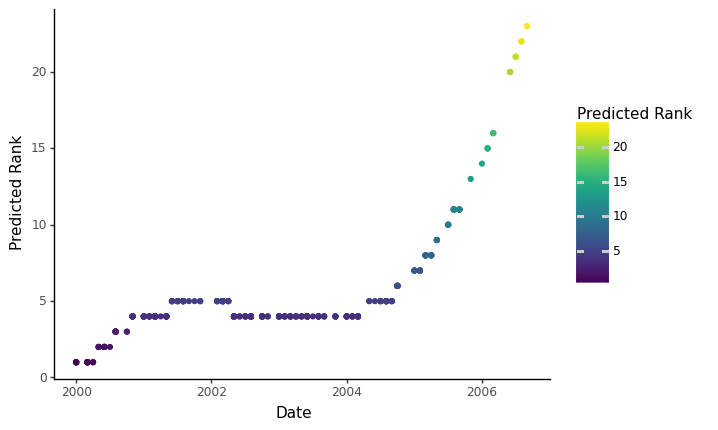

<ggplot: (8764430176050)>

In [19]:
ggDateRankex = pln.ggplot(data = pd.DataFrame({'Date':RankData.Date,'Predicted Rank':preds_rank}))
ggDateRankex + pln.geom_point(pln.aes(x='Date',y='Predicted Rank',colour= 'Predicted Rank'))+ pln.theme_classic()

In [20]:
preds_rank

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
        5.,  5.,  5.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4

The fitted model seems to be close enough to the true shape. We will use it for the whole set of players to impute the missing values of ranks.

In [21]:
#Players having missing ranks:
df_nan_RanksW = df_atp_Train.loc[df_atp_Train.WRank.isna(),['Date','Winner']].copy() 
df_nan_RanksL = df_atp_Train.loc[df_atp_Train.LRank.isna(),['Date','Loser']].copy() 
Trues0 = np.repeat(True, repeats=df_nan_RanksW.shape[0], axis=0)
Falses0 = np.repeat(False, repeats=df_nan_RanksL.shape[0], axis=0)

In [22]:
#Dataframe putting together all the players with NA's in Rank + Date of match + whether it's a winner or not
df_nan_Ranks = pd.DataFrame({'Date':pd.concat([df_nan_RanksW['Date'], df_nan_RanksL['Date']], axis=0),
                          'Player' : pd.concat([df_nan_RanksW['Winner'],df_nan_RanksL['Loser']], axis=0),
                         'isWinner':pd.Series(np.concatenate([Trues0,Falses0]).flatten(), 
                                            index=np.concatenate([df_nan_RanksW.index, df_nan_RanksL.index]))
                         })
df_nan_Ranks.sort_index(ascending=True, inplace=True)

In [23]:
df_nan_Ranks['DateFloat'] = df_nan_Ranks['Date'].apply(lambda x : x.year + (x.month-1)/12 + x.day/365)

In [24]:
df_nan_Ranks.head()

,Date,Player,isWinner,DateFloat
63,2000-01-03,Al-Alawi S.K.,False,2000.008219
377,2000-02-14,Jensen L.,False,2000.121689
560,2000-02-28,Roddick A.,False,2000.160046
611,2000-03-06,Gonzalez P.,False,2000.183105
613,2000-03-06,Hadad M.,False,2000.183105


In [25]:
#Preparing median values for rank-imputations in case 2 : 
medianRankW = np.median(df_atp_Train['WRank'])
print("Winners' median rank : "+str(medianRankW))
medianRankL = np.median(df_atp_Train['LRank'])
print("Losers' median rank : "+str(medianRankL))

Winners' median rank : 41.0
Losers' median rank : 65.0


In [26]:
def genMedianRank(lenWin, lenLose, medianRankW = medianRankW, medianRankL =medianRankL):
    """
    -Overview : 
    Rank Imputation function for case 2 players
    
    - Arguments : 
    lenWin , lenLose : number of won/lost matches for a given player 
    medianRankW , medianRankL :  Rank medians (Winner/Loser)
    
    - Returns :
    numpy array of juxtaposed Rank medians (Winner/Loser) . This will serve as an imputation vector (shape : (lenWin+lenLose))
    """
    return(np.concatenate([np.repeat(medianRankW, repeats=lenWin, axis=0),
                           np.repeat(medianRankL, repeats=lenLose, axis=0)]).flatten())

In order to handle Rank missing values in the test set, we're going to use the same per player fitted model 

In [27]:
def computeRankImput(Player, nanData = df_nan_Ranks ,sourceData = df_atp_Train):
    """
    - Overview :
    Rank Imputations Computing function for both cases (1 & 2)
    
    - Arguments :
    Player : [str] Player's name
    nanData : [pandas DataFrame] data of players with Rank missing values (plays the role of training data set)
    sourceData : [pandas DataFrame] target dataset to compute imputations (plays the role of test data set)
    
    - Returns : 
    [pandas Data Frame] : subset of nanData for the given Player + computed imputation values
    """
    
    winData = sourceData.loc[sourceData.Winner==Player,['Date', 'WRank']]
    loseData = sourceData.loc[sourceData.Loser==Player,['Date','LRank']]
    
    playerNanData = nanData.loc[nanData['Player']==Player,:].copy()
    
    RankData = pd.DataFrame({'Date':pd.concat([winData.Date, loseData.Date], axis=0), 
                             'Rank':pd.concat([winData.WRank, loseData.LRank], axis=0)})
    RankData.sort_index(inplace=True)
    RankData.dropna(inplace=True)
    RankData['Date'] = RankData['Date'].apply(lambda x : x.year + (x.month-1)/12)
    
    if(RankData.shape[0]==0):
        return(pd.concat([playerNanData, pd.DataFrame({'PredRank':genMedianRank(lenWin=len(winData),lenLose=len(loseData))},
                                                      index=playerNanData.index)], axis=1))
    
    indToDrop = RankData['Rank'].apply(lambda x : str(x).isalpha())
    indToDrop = indToDrop.index[indToDrop]
    RankData.drop(axis=0,index= indToDrop, inplace=True)
    
    polyDegree = round(np.log10(len(RankData)))     #polynomial degree depending on how much data we have (log like for example)
    RankData["Rank"] = RankData["Rank"].astype(float)    
    weights_date_rank = np.polyfit(RankData.Date, RankData.Rank, polyDegree)
    model_date_rank = np.poly1d(weights_date_rank)
    
    prediction = np.round(model_date_rank(playerNanData['DateFloat']))
    prediction[prediction<1] = 1
    
    result = pd.concat([playerNanData, pd.DataFrame({'PredRank':prediction}, index=playerNanData.index)], axis=1)
    return(result)

In [28]:
def imputeRankData(nanData = df_nan_Ranks ,sourceData = df_atp_Train, targetData = df_atp_Train):
    """
    - Overview :
    Inplace Rank Imputation of data passed as sourceData based on computed imputations by the previous function 'computeRankImput'
    
    -Arguments :
    nanData : [pandas DataFrame] data of players with Rank missing values
    sourceData : [pandas DataFrame] target dataset to be imputed
    
    -Returns:
    Inplace imputations (no return)
    Prints imputations progress
    """
    progress = 0
    nanPtsLen = len(nanData['Player'].unique())
    tenPer, per = nanPtsLen//10, 0
    for p in nanData['Player'].unique():
        imputations = computeRankImput(Player=p, nanData = nanData ,sourceData = sourceData)        
        for i,val in enumerate(imputations['isWinner']):
            imp = imputations.loc[imputations.index[i], 'PredRank']
            if (val): #Winner case
                targetData.loc[imputations.index[i],'WRank'] = imp
            else:     #Loser case
                targetData.loc[imputations.index[i],'LRank'] = imp
        if(per==progress):
            print("Imputations in progress "+str( np.round(100*per/nanPtsLen, decimals=0))+"%")
            per += tenPer
        progress += 1
        if(progress==nanPtsLen):
            print("Done !")

In [29]:
imputeRankData(nanData = df_nan_Ranks ,sourceData = df_atp_Train, targetData = df_atp_Train)

Imputations in progress 0.0%
Imputations in progress 9.0%
Imputations in progress 19.0%
Imputations in progress 28.0%
Imputations in progress 37.0%
Imputations in progress 47.0%
Imputations in progress 56.0%
Imputations in progress 65.0%
Imputations in progress 74.0%
Imputations in progress 84.0%
Imputations in progress 93.0%
Done !


In [30]:
print("Number of missing values in WRank column : " + str(sum(df_atp_Train.WRank.isna())))

Number of missing values in WRank column : 0


In [31]:
print("Number of missing values in LRank column : " + str(sum(df_atp_Train.LRank.isna())))

Number of missing values in LRank column : 0


In [32]:
df_atp_Train['WRank'] = df_atp_Train['WRank'].astype('int64')
df_atp_Train['LRank'] = df_atp_Train['LRank'].astype('int64')

We do the same for the test data set. This time, we can use even Ranks from Test Data to perform the interpolation (we couldn't do that before because we risk a Data Leakage).  

In [33]:
naRankIndWTest = df_atp_Test.loc[:,'WRank'].apply(lambda x: x=='NR') 
naRankIndLTest = df_atp_Test.loc[:,'LRank'].apply(lambda x: x=='NR')
df_atp_Test.loc[naRankIndWTest,'WRank'] = np.NaN
df_atp_Test.loc[naRankIndLTest,'LRank'] = np.NaN

In [34]:
print("Number of missing values in WRank column (Test data): " + str(sum(df_atp_Test.WRank.isna())))

Number of missing values in WRank column (Test data): 0


In [35]:
print("Number of missing values in LRank column (Test data): " + str(sum(df_atp_Test.LRank.isna())))

Number of missing values in LRank column (Test data): 6


In [36]:
#Players having missing ranks (In test):
df_nan_RanksL_T = df_atp_Test.loc[df_atp_Test.LRank.isna(),['Date','Loser']].copy() 
Falses0T = np.repeat(False, repeats=df_nan_RanksL_T.shape[0], axis=0)

#Dataframe putting together all the players with NA's in Rank + Date of match + whether it's a winner or not
df_nan_Ranks_T = pd.DataFrame({'Date':df_nan_RanksL_T['Date'],
                          'Player' : df_nan_RanksL_T['Loser'],
                         'isWinner':pd.Series(Falses0T, index=df_nan_RanksL_T.index)
                         })
df_nan_Ranks_T.sort_index(ascending=True, inplace=True)

df_nan_Ranks_T['DateFloat'] = df_nan_Ranks_T['Date'].apply(lambda x : x.year + (x.month-1)/12)

In [37]:
df_nan_Ranks_T

,Date,Player,isWinner,DateFloat
47124,2017-01-10,Sitak A.,False,2017.000000
47225,2017-01-17,Haas T.,False,2017.000000
47592,2017-02-28,Alawadhi O.,False,2017.083333
48235,2017-05-22,Kokkinakis T.,False,2017.333333
48310,2017-05-30,Kokkinakis T.,False,2017.333333
49286,2017-09-25,Pavic M.,False,2017.666667


In [38]:
imputeRankData(nanData = df_nan_Ranks_T ,sourceData = df_atp, targetData = df_atp_Test)

Imputations in progress 0.0%
Done !


In [39]:
print("Number of missing values in WRank column (Test data): " + str(sum(df_atp_Test.WRank.isna())))

Number of missing values in WRank column (Test data): 0


In [40]:
print("Number of missing values in LRank column (Test data): " + str(sum(df_atp_Test.LRank.isna())))

Number of missing values in LRank column (Test data): 0


Now that we have imputed all the missing values with numerical values, we can cast the Rank related variables to 'int64'.

In [41]:
df_atp_Test['WRank'] = df_atp_Test['WRank'].astype('int64')
df_atp_Test['LRank'] = df_atp_Test['LRank'].astype('int64')

### 1.3 - Imputation of Point-related missing values

Now, we'll try to handle Point-related missing values. The basic idea is to fit a simple regression model with the expression normalized(Point) = f(log(1+1/Rank)). We won't introduce time variable and deal with the problem as a covariant time series problem to make it simple since it's just about imputations, even if in reality, points notation has changed in the ATP ranking system. 

In [42]:
#Players having missing points :
nanPointsPlayersW = df_atp_Train.loc[df_atp_Train.WPts.isna(),['WRank','Winner']].copy() 
nanPointsPlayersL = df_atp_Train.loc[df_atp_Train.LPts.isna(),['LRank','Loser']].copy() 
Trues = np.repeat(True, repeats=nanPointsPlayersW.shape[0], axis=0)
Falses = np.repeat(False, repeats=nanPointsPlayersL.shape[0], axis=0)
df_nan_Points = pd.DataFrame({'Player':pd.concat([nanPointsPlayersW['Winner'], nanPointsPlayersL['Loser']], axis=0),
                                 'Rank':pd.concat([nanPointsPlayersW['WRank'], nanPointsPlayersL['LRank']], axis=0),
                                 'isWinner':pd.Series(np.concatenate([Trues,Falses]).flatten(), 
                                            index=np.concatenate([nanPointsPlayersW.index, nanPointsPlayersL.index]))})


In [43]:
#Preparing data for training the average model Points = f(Rank)
cleanData = df_atp_Train.loc[:,['WRank','LRank','WPts','LPts']].copy()
cleanData.dropna(axis=0, inplace=True)

PtsSerie = pd.concat([cleanData.LPts, cleanData.WPts], axis=0)
RankSeries = pd.concat([cleanData.LRank, cleanData.WRank], axis=0)
df_rank_points = pd.DataFrame({'Rank':RankSeries,'Points': PtsSerie })

df_rank_points.sort_values(axis=0, by='Rank', inplace=True)

In [44]:
#How rank-points looks like
df_rank_points.head()

,Rank,Points
47027,1,11185.0
27108,1,14960.0
27049,1,15360.0
27047,1,15360.0
27039,1,15360.0


Let's visualize the Rank-Point relationship for a given Date

In [45]:
df_rank_points = df_rank_points.groupby('Rank').aggregate('median')

In [46]:
df_rank_points.reset_index(inplace=True)

In [47]:
df_rank_points.head()

,Rank,Points
0,1,12040.0
1,2,8700.0
2,3,6745.0
3,4,5715.0
4,5,4840.0


In [48]:
XRank = df_rank_points.loc[:,'Rank'].values.reshape(-1, 1)
YRank = df_rank_points.loc[:,'Points'].values.reshape(-1, 1)

In [49]:
RfRegressor=RandomForestRegressor(n_estimators=2200, random_state=1995, min_samples_leaf=5, max_features=1, criterion='mse' )

In [50]:
RfRegressor.fit(XRank, YRank.squeeze())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2200, n_jobs=None, oob_score=False,
                      random_state=1995, verbose=0, warm_start=False)

In [51]:
predictedPoints = RfRegressor.predict(XRank)

Text(0.5, 1.0, 'True Point values Vs Fitted values')

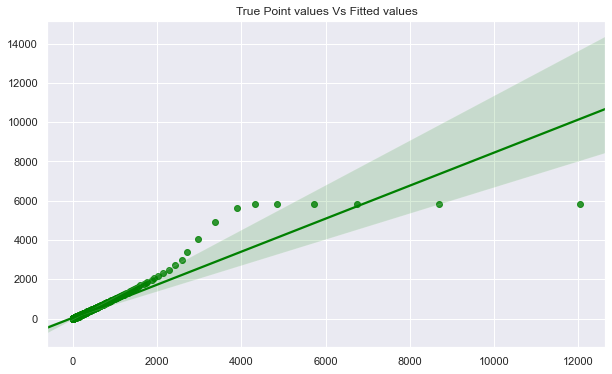

In [52]:
fig, ax = plt.subplots(figsize=(10,6))
sns.regplot(x= YRank.squeeze(), y = predictedPoints, color='green', ax=ax)
plt.title('True Point values Vs Fitted values')

In [53]:
pd.DataFrame({'Point':YRank.squeeze()}).quantile(0.98).values

array([1870.4])

More than **98% of Points lay bellow 2000** and thus the model can be used for interpolation

In [54]:
def avgRankPointPred(ranks ,model = RfRegressor):
    """
    -Overview : 
    Point Imputations Computing function (based on a pre-trained model passed as argument)
    
    - Arguments : 
    ranks : Player's ranks  
    model : Fitted model for Prediction
    
    - Returns :
    numpy array of predicted points values by the model passed in argument (will serve for imputation)
    """
    myranks = np.array(ranks).reshape((len(ranks),1))
    Ypreds = np.round(model.predict(myranks))
    return(Ypreds)

In [55]:
def computePointImput(Player, nanData = df_nan_Points ,targetData = df_atp_Train):
    """
    - Overview :
    Points Imputations Computing function
    
    - Arguments :
    Player : [str] Player's name
    nanData : [pandas DataFrame] data of players with Points missing values (plays the role of training data set)
    targetData : [pandas DataFrame] target dataset to compute imputations (plays the role of test data set)
    
    - Returns : 
    [pandas Data Frame] : subset of nanData for the given Player + computed imputation values of points
    """
    
    winData = targetData.loc[targetData.Winner==Player,['WRank', 'WPts']]
    loseData = targetData.loc[targetData.Loser==Player,['LRank','LPts']]
    
    playerNanData = nanData.loc[nanData['Player']==Player,:].copy()
    
    PointData = pd.DataFrame({ 'Rank':pd.concat([winData['WRank'], loseData['LRank']], axis=0),
                             'Points':pd.concat([winData['WPts'], loseData['LPts']], axis=0)})
    PointData.sort_index(inplace=True)
    PointData.dropna(inplace=True)
    predPoints = avgRankPointPred(playerNanData['Rank'])
    output = pd.concat([playerNanData, pd.DataFrame({'PredPoint':predPoints}, index=playerNanData.index)], axis=1)
    return(output)

In [56]:
def imputePointsData(nanData = df_nan_Points ,targetData = df_atp_Train):
    """
    - Overview :
    Inplace Points Imputation of data passed as targetData based on computed imputations by the previous function 'computePointImput'
    
    -Arguments :
    nanData : [pandas DataFrame] data of players with Points missing values
    targetData : [pandas DataFrame] target dataset to be imputed
    
    -Returns:
    Inplace imputations (no return)
    Prints imputations progress
    """
    progress = 0
    nanPtsLen = len(nanData['Player'].unique())
    tenPer, per = nanPtsLen//10, 0
    for p in nanData['Player'].unique():
        imputations = computePointImput(Player=p, nanData = nanData ,targetData = targetData)        
        for i,val in enumerate(imputations['isWinner']):
            imp = imputations.loc[imputations.index[i], 'PredPoint']
            if (val): #Winner case
                targetData.loc[imputations.index[i],'WPts'] = imp
            else:     #Loser case
                targetData.loc[imputations.index[i],'LPts'] = imp
        if(per==progress):
            print("Imputations in progress "+str( np.round(100*per/nanPtsLen, decimals=0))+"%")
            per += tenPer
        progress += 1
        if(progress==nanPtsLen):
            print("Done !")

In [57]:
imputePointsData(nanData = df_nan_Points ,targetData = df_atp_Train)

Imputations in progress 0.0%
Imputations in progress 10.0%
Imputations in progress 20.0%
Imputations in progress 30.0%
Imputations in progress 40.0%
Imputations in progress 50.0%
Imputations in progress 60.0%
Imputations in progress 69.0%
Imputations in progress 79.0%
Imputations in progress 89.0%
Imputations in progress 99.0%
Done !


In [58]:
print("Percentage of missing values in WPts column : " + str(np.round(100*sum(df_atp_Train.WPts.isna())/len(df_atp_Train), 3))+"%")
print("Percentage of missing values in LPts column : " + str(np.round(100*sum(df_atp_Train.LPts.isna())/len(df_atp_Train), 3))+"%")

Percentage of missing values in WPts column : 0.0%
Percentage of missing values in LPts column : 0.0%


In [59]:
df_atp_Train['WPts'] = df_atp_Train['WPts'].astype('int64')
df_atp_Train['LPts'] = df_atp_Train['LPts'].astype('int64')

Quick comparison between some observations before/after na imputation:

In [60]:
df_atp_Train.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,AvgW,AvgL,MaxW,MaxL
0,3,Outdoor,2000-01-03,648,77,Ljubicic I.,1st Round,International,Hard,Australian Hardcourt Championships,755,63,Dosedel S.,NaN,NaN,NaN,NaN
1,3,Outdoor,2000-01-03,818,56,Clement A.,1st Round,International,Hard,Australian Hardcourt Championships,5858,5,Enqvist T.,NaN,NaN,NaN,NaN
2,3,Outdoor,2000-01-03,36,655,Baccanello P.,1st Round,International,Hard,Australian Hardcourt Championships,1025,40,Escude N.,NaN,NaN,NaN,NaN
3,3,Outdoor,2000-01-03,588,87,Knippschild J.,1st Round,International,Hard,Australian Hardcourt Championships,736,65,Federer R.,NaN,NaN,NaN,NaN
4,3,Outdoor,2000-01-03,254,198,Woodbridge T.,1st Round,International,Hard,Australian Hardcourt Championships,625,81,Fromberg R.,NaN,NaN,NaN,NaN


In [61]:
df_atp.loc[:,usedColumns].head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,AvgW,AvgL,MaxW,MaxL
0,3,Outdoor,2000-01-03,NaN,77,Ljubicic I.,1st Round,International,Hard,Australian Hardcourt Championships,NaN,63,Dosedel S.,NaN,NaN,NaN,NaN
1,3,Outdoor,2000-01-03,NaN,56,Clement A.,1st Round,International,Hard,Australian Hardcourt Championships,NaN,5,Enqvist T.,NaN,NaN,NaN,NaN
2,3,Outdoor,2000-01-03,NaN,655,Baccanello P.,1st Round,International,Hard,Australian Hardcourt Championships,NaN,40,Escude N.,NaN,NaN,NaN,NaN
3,3,Outdoor,2000-01-03,NaN,87,Knippschild J.,1st Round,International,Hard,Australian Hardcourt Championships,NaN,65,Federer R.,NaN,NaN,NaN,NaN
4,3,Outdoor,2000-01-03,NaN,198,Woodbridge T.,1st Round,International,Hard,Australian Hardcourt Championships,NaN,81,Fromberg R.,NaN,NaN,NaN,NaN


Now, we do the same for the test set.

In [62]:
print("Percentage of missing values in WPts column (Test) : " + str(np.round(100*sum(df_atp_Test.WPts.isna())/len(df_atp_Test), 3))+"%")
print("Percentage of missing values in LPts column (Test) : " + str(np.round(100*sum(df_atp_Test.LPts.isna())/len(df_atp_Test), 3))+"%")

Percentage of missing values in WPts column (Test) : 0.0%
Percentage of missing values in LPts column (Test) : 0.228%


In [63]:
#Players having missing points :
nanPointsPlayersL_T = df_atp_Test.loc[df_atp_Test.LPts.isna(),['LRank','Loser']].copy() 
FalsesT = np.repeat(False, repeats=nanPointsPlayersL_T.shape[0], axis=0)
df_nan_Points_Test = pd.DataFrame({'Player':nanPointsPlayersL_T['Loser'],
                                 'Rank':nanPointsPlayersL_T['LRank'],
                                 'isWinner':pd.Series(FalsesT, index = nanPointsPlayersL_T.index)
                                  })



In [64]:
imputePointsData(nanData = df_nan_Points_Test ,targetData = df_atp_Test)

Imputations in progress 0.0%
Done !


In [65]:
print("Percentage of missing values in WPts column (Test) : " + str(np.round(100*sum(df_atp_Test.WPts.isna())/len(df_atp_Test), 3))+"%")
print("Percentage of missing values in LPts column (Test) : " + str(np.round(100*sum(df_atp_Test.LPts.isna())/len(df_atp_Test), 3))+"%")

Percentage of missing values in WPts column (Test) : 0.0%
Percentage of missing values in LPts column (Test) : 0.0%


In [66]:
df_atp_Test['WPts'] = df_atp_Test['WPts'].astype('int64')
df_atp_Test['LPts'] = df_atp_Test['LPts'].astype('int64')

## Feature Engineering  
### Output modeling  
If we define the outcome of an ATP match as the 'Winner's name', the problem would be a multi-classification task with an output taking labels belonging to the names of all players since 2000. This 'naive' approach is not realistic since for each match we have two players and the winner is among them. One way to explore that is to consider two aditionnal features 'player1' and 'player2' to which we randomly assign the match winner and loser, the target variable would belong to the couple (0,1) and thus the problem can be treated as a **binary classification** learning.

In [67]:
df_atp_Train[['Player1','Player2']] = df_atp_Train.loc[:,['Winner','Loser']]
df_atp_Train.head(50)

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,AvgW,AvgL,MaxW,MaxL,Player1,Player2
0,3,Outdoor,2000-01-03,648,77,Ljubicic I.,1st Round,International,Hard,Australian Hardcourt Championships,755,63,Dosedel S.,NaN,NaN,NaN,NaN,Dosedel S.,Ljubicic I.
1,3,Outdoor,2000-01-03,818,56,Clement A.,1st Round,International,Hard,Australian Hardcourt Championships,5858,5,Enqvist T.,NaN,NaN,NaN,NaN,Enqvist T.,Clement A.
2,3,Outdoor,2000-01-03,36,655,Baccanello P.,1st Round,International,Hard,Australian Hardcourt Championships,1025,40,Escude N.,NaN,NaN,NaN,NaN,Escude N.,Baccanello P.
3,3,Outdoor,2000-01-03,588,87,Knippschild J.,1st Round,International,Hard,Australian Hardcourt Championships,736,65,Federer R.,NaN,NaN,NaN,NaN,Federer R.,Knippschild J.
4,3,Outdoor,2000-01-03,254,198,Woodbridge T.,1st Round,International,Hard,Australian Hardcourt Championships,625,81,Fromberg R.,NaN,NaN,NaN,NaN,Fromberg R.,Woodbridge T.
5,3,Outdoor,2000-01-03,517,105,Arthurs W.,1st Round,International,Hard,Australian Hardcourt Championships,789,58,Gambill J.M.,NaN,NaN,NaN,NaN,Gambill J.M.,Arthurs W.
6,3,Outdoor,2000-01-03,869,51,Ilie A.,1st Round,International,Hard,Australian Hardcourt Championships,1402,26,Grosjean S.,NaN,NaN,NaN,NaN,Grosjean S.,Ilie A.
7,3,Outdoor,2000-01-03,218,218,Balcells J.,1st Round,International,Hard,Australian Hardcourt Championships,2993,11,Henman T.,NaN,NaN,NaN,NaN,Henman T.,Balcells J.
8,3,Outdoor,2000-01-03,422,129,Woodforde M.,1st Round,International,Hard,Australian Hardcourt Championships,1493,24,Hewitt L.,NaN,NaN,NaN,NaN,Hewitt L.,Woodforde M.
9,3,Outdoor,2000-01-03,113,351,Tebbutt M.,1st Round,International,Hard,Australian Hardcourt Championships,406,134,Lisnard J.,NaN,NaN,NaN,NaN,Lisnard J.,Tebbutt M.


In [68]:
np.random.seed(1995)

In [69]:
Won = np.random.randint(2,size=len(df_atp_Train))

In [70]:
df_atp_Train['Won'] = Won
boolWon = (Won==0)

In [71]:
df_atp_Train.loc[boolWon,'Player1'] , df_atp_Train.loc[boolWon,'Player2'] = df_atp_Train.loc[boolWon,'Player2'], df_atp_Train.loc[boolWon,'Player1'] 

In [72]:
df_atp_Train.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,AvgW,AvgL,MaxW,MaxL,Player1,Player2,Won
0,3,Outdoor,2000-01-03,648,77,Ljubicic I.,1st Round,International,Hard,Australian Hardcourt Championships,755,63,Dosedel S.,NaN,NaN,NaN,NaN,Ljubicic I.,Dosedel S.,0
1,3,Outdoor,2000-01-03,818,56,Clement A.,1st Round,International,Hard,Australian Hardcourt Championships,5858,5,Enqvist T.,NaN,NaN,NaN,NaN,Clement A.,Enqvist T.,0
2,3,Outdoor,2000-01-03,36,655,Baccanello P.,1st Round,International,Hard,Australian Hardcourt Championships,1025,40,Escude N.,NaN,NaN,NaN,NaN,Baccanello P.,Escude N.,0
3,3,Outdoor,2000-01-03,588,87,Knippschild J.,1st Round,International,Hard,Australian Hardcourt Championships,736,65,Federer R.,NaN,NaN,NaN,NaN,Federer R.,Knippschild J.,1
4,3,Outdoor,2000-01-03,254,198,Woodbridge T.,1st Round,International,Hard,Australian Hardcourt Championships,625,81,Fromberg R.,NaN,NaN,NaN,NaN,Fromberg R.,Woodbridge T.,1


We do the same for the test set.

In [73]:
df_atp_Test[['Player1','Player2']] = df_atp_Test.loc[:,['Winner','Loser']]
df_atp_Test.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,AvgW,AvgL,MaxW,MaxL,Player1,Player2
47028,3,Outdoor,2017-01-01,372,160,Ymer E.,1st Round,ATP250,Hard,Brisbane International,689,79,Thompson J.,1.29,3.50,1.33,3.90,Thompson J.,Ymer E.
47029,3,Outdoor,2017-01-02,854,54,Robert S.,1st Round,ATP250,Hard,Brisbane International,1102,39,Mahut N.,1.54,2.43,1.59,2.55,Mahut N.,Robert S.
47030,3,Outdoor,2017-01-02,1465,26,Tomic B.,1st Round,ATP250,Hard,Brisbane International,1785,21,Ferrer D.,2.01,1.77,2.15,1.82,Ferrer D.,Tomic B.
47031,3,Outdoor,2017-01-02,443,141,Escobedo E.,1st Round,ATP250,Hard,Brisbane International,1001,45,Edmund K.,1.37,3.01,1.42,3.25,Edmund K.,Escobedo E.
47032,3,Outdoor,2017-01-02,1320,33,Johnson S.,1st Round,ATP250,Hard,Brisbane International,2035,17,Dimitrov G.,1.41,2.85,1.46,3.13,Dimitrov G.,Johnson S.


In [74]:
WonT = np.random.randint(2,size=len(df_atp_Test))
boolWonT = (WonT==0)
df_atp_Test['Won'] = WonT

In [75]:
df_atp_Test.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,AvgW,AvgL,MaxW,MaxL,Player1,Player2,Won
47028,3,Outdoor,2017-01-01,372,160,Ymer E.,1st Round,ATP250,Hard,Brisbane International,689,79,Thompson J.,1.29,3.50,1.33,3.90,Thompson J.,Ymer E.,0
47029,3,Outdoor,2017-01-02,854,54,Robert S.,1st Round,ATP250,Hard,Brisbane International,1102,39,Mahut N.,1.54,2.43,1.59,2.55,Mahut N.,Robert S.,0
47030,3,Outdoor,2017-01-02,1465,26,Tomic B.,1st Round,ATP250,Hard,Brisbane International,1785,21,Ferrer D.,2.01,1.77,2.15,1.82,Ferrer D.,Tomic B.,1
47031,3,Outdoor,2017-01-02,443,141,Escobedo E.,1st Round,ATP250,Hard,Brisbane International,1001,45,Edmund K.,1.37,3.01,1.42,3.25,Edmund K.,Escobedo E.,0
47032,3,Outdoor,2017-01-02,1320,33,Johnson S.,1st Round,ATP250,Hard,Brisbane International,2035,17,Dimitrov G.,1.41,2.85,1.46,3.13,Dimitrov G.,Johnson S.,0


In [76]:
df_atp_Test.loc[boolWonT,'Player1'] , df_atp_Test.loc[boolWonT,'Player2'] = df_atp_Test.loc[boolWonT,'Player2'], df_atp_Test.loc[boolWonT,'Player1'] 

In [77]:
df_atp_Test.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,WPts,WRank,Winner,AvgW,AvgL,MaxW,MaxL,Player1,Player2,Won
47028,3,Outdoor,2017-01-01,372,160,Ymer E.,1st Round,ATP250,Hard,Brisbane International,689,79,Thompson J.,1.29,3.50,1.33,3.90,Ymer E.,Thompson J.,0
47029,3,Outdoor,2017-01-02,854,54,Robert S.,1st Round,ATP250,Hard,Brisbane International,1102,39,Mahut N.,1.54,2.43,1.59,2.55,Robert S.,Mahut N.,0
47030,3,Outdoor,2017-01-02,1465,26,Tomic B.,1st Round,ATP250,Hard,Brisbane International,1785,21,Ferrer D.,2.01,1.77,2.15,1.82,Ferrer D.,Tomic B.,1
47031,3,Outdoor,2017-01-02,443,141,Escobedo E.,1st Round,ATP250,Hard,Brisbane International,1001,45,Edmund K.,1.37,3.01,1.42,3.25,Escobedo E.,Edmund K.,0
47032,3,Outdoor,2017-01-02,1320,33,Johnson S.,1st Round,ATP250,Hard,Brisbane International,2035,17,Dimitrov G.,1.41,2.85,1.46,3.13,Johnson S.,Dimitrov G.,0


### Feature creation  
#### Player1 Vs Player2  
head-to-head wins variable : count of all times when player1 beated player2 minus the count of all times when player2 beated player1 before the year of the match (since it doesn't make sense to aggregate with the whole data, only past records should explain future results).  


In [78]:
df_atp_Train['Year'] = df_atp_Train.Date.apply(lambda x : x.year)

In [79]:
df_atp_Test['Year'] = df_atp_Test.Date.apply(lambda x : x.year)

In [80]:
def recordedVs(Year, data, past = 17, includeYear = False):
    """
    Overview:
    For a given year, computes all the recorded relative victories of the duels. (Nb of winnings/ Nb of matches)
    
    Arguments:
    - Year : [scalar] the year of the match, the computations will use the data recorded before that year
    - data : [data frame] Train data set that contains the whole records from 2000 to 2016
    - past : number of years to be used for 
    
    Returns : 
    A dataframe with the Winner, Loser, winning rate of the winner in the past (<Year)
    
    *The victories are also weighted with the number of Sets played (Best Of) since a value of 3 means at least two
    successive victories (high margin) while 5 indicates a certain difficulty (low margin )
    
    
    """
    pastYears = np.min([past, Year-2000])   #Since the oldest record was in year 2000
    if includeYear:
        includeY = 1
    else:
        includeY = 0
    
    df_sub = data.loc[(Year-pastYears <= data.Year) & (data.Year<Year+includeY),['Best of','Winner','Loser']].copy()
    df_sub['CouplesSet'] = df_sub.apply(lambda x : str(set((x['Winner'], x['Loser']))), axis=1)
    countSets = df_sub.CouplesSet.value_counts()
    countSets = pd.DataFrame({'couplePlayer':countSets.index, 'NMatche':countSets.values})
    countWons = df_sub.groupby(['Winner','Loser'])
    countWons = countWons.aggregate(['count','mean'])
    countWons.reset_index(inplace=True)
    countWons['CountWon'] = countWons.loc[:,('Best of','count')]
    countWons['MeanBestOf'] = countWons.loc[:,('Best of','mean')]
    countWons.drop(axis=1, columns='Best of', level=0, inplace=True)
    countWons['relativeVictory'] = 0.0
    countWIndx = countWons.index
    countSIndx = countSets.index
    
    for i in range(len(countWons)):
        p1 = countWons.loc[countWIndx[i],'Winner'].values[0]
        p2 = countWons.loc[countWIndx[i],'Loser'].values[0]
    
        Nindex = countSIndx[countSets.couplePlayer.apply(lambda x : (p1 in x) & (p2 in x) )]
        N = countSets.loc[Nindex, 'NMatche']
        countWons.loc[countWIndx[i],'relativeVictory'] = np.asscalar(countWons.loc[countWIndx[i],'CountWon']/N.values[0])
    return(countWons)
    
    

In [81]:
genHistory = recordedVs(2017, data = df_atp_Train, past = 17, includeYear=False)

In [82]:
genHistoryTest = recordedVs(2017, data = df_atp_Train, past = 10, includeYear=True)

Here are some match cases with the computed values of head to head results. For example, Federer won Agassi in 80% of their games, so he lost the left 20%. We see it clearly in the observations bellow.

In [83]:
genHistory.loc[(genHistory.Winner== 'Clement A.')&(genHistory.Loser=='Enqvist T.'),:]

,Winner,Loser,CountWon,MeanBestOf,relativeVictory
,,,,,
4977,Clement A.,Enqvist T.,1,5.0,0.25


In [84]:
genHistory.loc[(genHistory.Winner == 'Clement A.') &(genHistory.Loser=='Enqvist T.'),:]

,Winner,Loser,CountWon,MeanBestOf,relativeVictory
,,,,,
4977,Clement A.,Enqvist T.,1,5.0,0.25


Another special case is when a player X have won all the matches against player Y, so the results will be 100% and 0%.

In [85]:
genHistory.loc[(genHistory.Winner=='Hajek J.') & (genHistory.Loser=='Ulihrach B.'),:]

,Winner,Loser,CountWon,MeanBestOf,relativeVictory
,,,,,
11954,Hajek J.,Ulihrach B.,1,5.0,1.0


In [86]:
genHistory.loc[(genHistory.Loser=='Hajek J.') & (genHistory.Winner=='Ulihrach B.'),:]

,Winner,Loser,CountWon,MeanBestOf,relativeVictory
,,,,,


Now we can fill the values for the new features 'p1Vsp2' and 'Wp1Vsp2' based on the records in the 'genHistory' dataset.

In [87]:
df_atp_Train['p1Vsp2'] = 0
df_atp_Train['Wp1Vsp2'] = 0

In [88]:
def p1Vsp2(data, history = genHistory):

    dataIndex = data.index
    progress = 0
    dataLenght = len(data)
    tenPer, per = dataLenght//10, 0

    for i in dataIndex:
        p1 = data.loc[i,'Player1']
        p2 = data.loc[i,'Player2']
        relVict = history.loc[((history.Winner==p1) & (history.Loser==p2)),'relativeVictory' ]
        relLoss = history.loc[((history.Winner==p2) & (history.Loser==p1)),'relativeVictory' ]
        
        if len(relVict)==0:
            relVict = 0
        else:
            relVict = np.asscalar(relVict.values)
        if len(relLoss)==0:
            relLoss = 0  
        else:
            relLoss = np.asscalar(relLoss.values)
        
     
        MeanSetsW = history.loc[((history.Winner==p1) & (history.Loser==p2)),'MeanBestOf' ]
        MeanSetsL = history.loc[((history.Loser==p1) & (history.Winner==p2)),'MeanBestOf' ]
    
        if len(MeanSetsW)==0:
            MeanSetsW = 3
        else:
            MeanSetsW = np.asscalar(MeanSetsW.values)
        if len(MeanSetsL)==0:
            MeanSetsL = 3
        else:
            MeanSetsL = np.asscalar(MeanSetsL.values)
        
        WrelVict = relVict/MeanSetsW
        LrelVict = relLoss/MeanSetsL
    
    
        data.loc[i,'p1Vsp2'] = relVict - relLoss
        data.loc[i,'Wp1Vsp2'] = WrelVict - LrelVict
    
        if(per==progress):
            print("Computations in progress "+str( np.round(100*per/dataLenght, decimals=0))+"%")
            per += tenPer
        progress += 1
        if(progress==dataLenght):
            print("Done !")




In [89]:
p1Vsp2(data = df_atp_Train, history = genHistory)

Computations in progress 0.0%
Computations in progress 10.0%
Computations in progress 20.0%
Computations in progress 30.0%
Computations in progress 40.0%
Computations in progress 50.0%
Computations in progress 60.0%
Computations in progress 70.0%
Computations in progress 80.0%
Computations in progress 90.0%
Computations in progress 100.0%
Done !


In [90]:
df_atp_Train.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,...,AvgW,AvgL,MaxW,MaxL,Player1,Player2,Won,Year,p1Vsp2,Wp1Vsp2
0,3,Outdoor,2000-01-03,648,77,Ljubicic I.,1st Round,International,Hard,Australian Hardcourt Championships,...,NaN,NaN,NaN,NaN,Ljubicic I.,Dosedel S.,0,2000,-1.0,-0.333333
1,3,Outdoor,2000-01-03,818,56,Clement A.,1st Round,International,Hard,Australian Hardcourt Championships,...,NaN,NaN,NaN,NaN,Clement A.,Enqvist T.,0,2000,-0.5,-0.200000
2,3,Outdoor,2000-01-03,36,655,Baccanello P.,1st Round,International,Hard,Australian Hardcourt Championships,...,NaN,NaN,NaN,NaN,Baccanello P.,Escude N.,0,2000,-1.0,-0.333333
3,3,Outdoor,2000-01-03,588,87,Knippschild J.,1st Round,International,Hard,Australian Hardcourt Championships,...,NaN,NaN,NaN,NaN,Federer R.,Knippschild J.,1,2000,1.0,0.333333
4,3,Outdoor,2000-01-03,254,198,Woodbridge T.,1st Round,International,Hard,Australian Hardcourt Championships,...,NaN,NaN,NaN,NaN,Fromberg R.,Woodbridge T.,1,2000,1.0,0.333333


Let's visualize the relationship between these added features and the output 'Won'

Text(0.5, 1.0, 'Boxplot of p1Vsp2 varialbe by winning case (Train Set)')

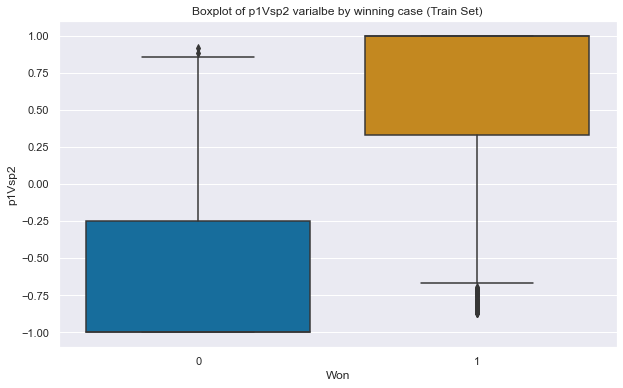

In [91]:
fig, ax = plt.subplots(figsize=(10,6))
bplot = sns.boxplot(y='p1Vsp2', x='Won', data=df_atp_Train, palette="colorblind")
plt.title('Boxplot of p1Vsp2 varialbe by winning case (Train Set)')

Text(0.5, 1.0, 'Boxplot of Wp1Vsp2 varialbe by winning case (Train Set)')

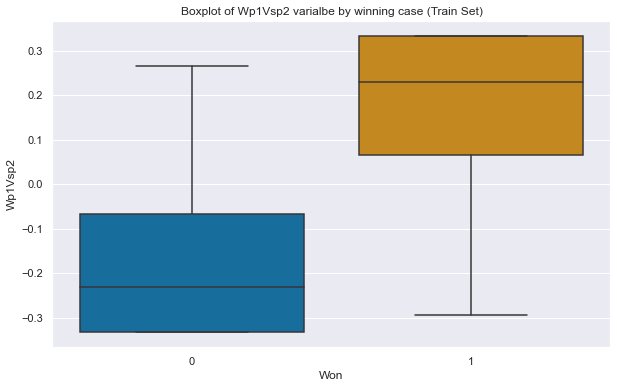

In [92]:
fig, ax = plt.subplots(figsize=(10,6))
bplot = sns.boxplot(y='Wp1Vsp2', x='Won', data=df_atp_Train, palette="colorblind")
plt.title('Boxplot of Wp1Vsp2 varialbe by winning case (Train Set)')

We have clearly a great separation between the winning/losing cases from the angle of the two added features 'p1Vsp2' and 'p2Vsp1'

We create the same 'Head to Head' features for the Test set based on recent historical data (from 2012->2017)

In [93]:
df_atp_Test['p1Vsp2'] = 0
df_atp_Test['Wp1Vsp2'] = 0

In [94]:
p1Vsp2(data = df_atp_Test, history = genHistoryTest)

Computations in progress 0.0%
Computations in progress 10.0%
Computations in progress 20.0%
Computations in progress 30.0%
Computations in progress 40.0%
Computations in progress 50.0%
Computations in progress 60.0%
Computations in progress 70.0%
Computations in progress 80.0%
Computations in progress 90.0%
Computations in progress 100.0%
Done !


In [95]:
df_atp_Test.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,...,AvgW,AvgL,MaxW,MaxL,Player1,Player2,Won,Year,p1Vsp2,Wp1Vsp2
47028,3,Outdoor,2017-01-01,372,160,Ymer E.,1st Round,ATP250,Hard,Brisbane International,...,1.29,3.50,1.33,3.90,Ymer E.,Thompson J.,0,2017,0.000000,0.000000
47029,3,Outdoor,2017-01-02,854,54,Robert S.,1st Round,ATP250,Hard,Brisbane International,...,1.54,2.43,1.59,2.55,Robert S.,Mahut N.,0,2017,0.000000,0.000000
47030,3,Outdoor,2017-01-02,1465,26,Tomic B.,1st Round,ATP250,Hard,Brisbane International,...,2.01,1.77,2.15,1.82,Ferrer D.,Tomic B.,1,2017,0.333333,0.079365
47031,3,Outdoor,2017-01-02,443,141,Escobedo E.,1st Round,ATP250,Hard,Brisbane International,...,1.37,3.01,1.42,3.25,Escobedo E.,Edmund K.,0,2017,-1.000000,-0.200000
47032,3,Outdoor,2017-01-02,1320,33,Johnson S.,1st Round,ATP250,Hard,Brisbane International,...,1.41,2.85,1.46,3.13,Johnson S.,Dimitrov G.,0,2017,-0.200000,-0.063636


Text(0.5, 1.0, 'Boxplot of p1Vsp2 varialbe by winning case (Test Set)')

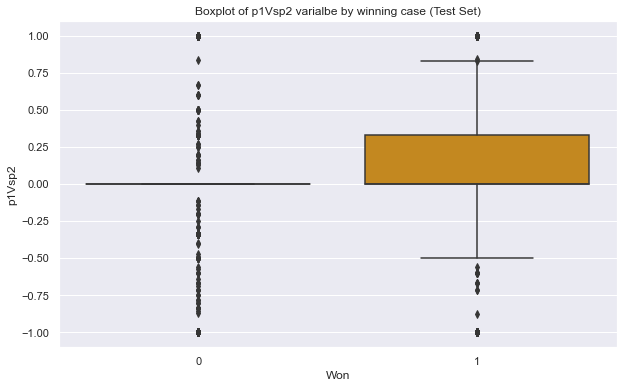

In [96]:
fig, ax = plt.subplots(figsize=(10,6))
bplot = sns.boxplot(y='p1Vsp2', x='Won', data=df_atp_Test, palette="colorblind")
plt.title('Boxplot of p1Vsp2 varialbe by winning case (Test Set)')

Separation seems more challenging in the Test set, this will probably lead to some misclassifications in the model.

#### Rank and Points differences (Player1 - Player2)    
The two features we're going to introduce are simply the difference between players performances (Points and Ranks).  

In [97]:
df_atp_Train["RankDiff"] = 0
df_atp_Train["PtsDiff"] = 0
df_atp_Train["OddsDiff"] = 0
df_atp_Train["MaxOddsDiff"] = 0

In [98]:
def performanceDiff(variable = 'Rank', targetData=df_atp_Train):
    """
    Overview:
    Computing and filling the difference of a given variable between the two players p1-p2
    
    Arguments : 
    variable : 'Rank' or 'Point'
    targetData : dataframe to be filled with differences (must contain at least the )
    
    Returns :
    inplace filling of the differences

    """
    if variable == 'Rank':
        Wval, Lval = 'WRank', 'LRank'
        target = "RankDiff"
        differences = targetData[Lval]-targetData[Wval]
    elif variable == 'Point':
        Wval, Lval = 'WPts', 'LPts'
        target = "PtsDiff"
        differences = targetData[Wval]-targetData[Lval]
    elif variable == "Odds":
        Wval,Lval = 'AvgW', 'AvgL'
        target = "OddsDiff"
        differences = targetData[Wval]-targetData[Lval]
    elif variable == "MAX":
        Wval,Lval = 'MaxW', 'MaxL'
        target = "MaxOddsDiff"
        differences = targetData[Wval]-targetData[Lval]
        
    targetData[target] = differences
    wonInd1 = targetData['Won'] == 0   #The cases where p1=Loser and p2=Winner 
    targetData.loc[wonInd1,target] = targetData.loc[wonInd1,target].apply(lambda x : -x)

In [99]:
performanceDiff(variable='Rank', targetData=df_atp_Train)

In [100]:
df_atp_Train.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,...,Player1,Player2,Won,Year,p1Vsp2,Wp1Vsp2,RankDiff,PtsDiff,OddsDiff,MaxOddsDiff
0,3,Outdoor,2000-01-03,648,77,Ljubicic I.,1st Round,International,Hard,Australian Hardcourt Championships,...,Ljubicic I.,Dosedel S.,0,2000,-1.0,-0.333333,-14,0,0,0
1,3,Outdoor,2000-01-03,818,56,Clement A.,1st Round,International,Hard,Australian Hardcourt Championships,...,Clement A.,Enqvist T.,0,2000,-0.5,-0.200000,-51,0,0,0
2,3,Outdoor,2000-01-03,36,655,Baccanello P.,1st Round,International,Hard,Australian Hardcourt Championships,...,Baccanello P.,Escude N.,0,2000,-1.0,-0.333333,-615,0,0,0
3,3,Outdoor,2000-01-03,588,87,Knippschild J.,1st Round,International,Hard,Australian Hardcourt Championships,...,Federer R.,Knippschild J.,1,2000,1.0,0.333333,22,0,0,0
4,3,Outdoor,2000-01-03,254,198,Woodbridge T.,1st Round,International,Hard,Australian Hardcourt Championships,...,Fromberg R.,Woodbridge T.,1,2000,1.0,0.333333,117,0,0,0


In [101]:
performanceDiff(variable='Point', targetData=df_atp_Train)

In [102]:
performanceDiff(variable='Odds', targetData=df_atp_Train)

In [103]:
performanceDiff(variable='MAX', targetData=df_atp_Train)

In [104]:
df_atp_Train.loc[df_atp_Train['Winner'] == "Federer R."]


,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,...,Player1,Player2,Won,Year,p1Vsp2,Wp1Vsp2,RankDiff,PtsDiff,OddsDiff,MaxOddsDiff
3,3,Outdoor,2000-01-03,588,87,Knippschild J.,1st Round,International,Hard,Australian Hardcourt Championships,...,Federer R.,Knippschild J.,1,2000,1.000000,0.333333,22,148,NaN,NaN
168,5,Outdoor,2000-01-17,1073,38,Chang M.,1st Round,Grand Slam,Hard,Australian Open,...,Federer R.,Chang M.,1,2000,0.600000,0.111111,-24,-308,NaN,NaN
229,5,Outdoor,2000-01-17,519,104,Kroslak J.,2nd Round,Grand Slam,Hard,Australian Open,...,Kroslak J.,Federer R.,0,2000,-1.000000,-0.200000,-42,-246,NaN,NaN
316,3,Indoor,2000-02-07,568,93,Dupuis A.,1st Round,International,Hard,Marseille Open,...,Federer R.,Dupuis A.,1,2000,1.000000,0.333333,26,148,NaN,NaN
329,3,Indoor,2000-02-07,1011,41,Johansson T.,2nd Round,International,Hard,Marseille Open,...,Federer R.,Johansson T.,1,2000,1.000000,0.307692,-26,-295,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45950,5,Outdoor,2016-06-27,919,52,Pella G.,1st Round,Grand Slam,Grass,Wimbledon,...,Pella G.,Federer R.,0,2016,-1.000000,-0.200000,-49,-5506,19.57,32.98
45985,5,Outdoor,2016-06-29,26,772,Willis M.,2nd Round,Grand Slam,Grass,Wimbledon,...,Federer R.,Willis M.,1,2016,1.000000,0.200000,769,6399,-16.82,-24.97
46016,5,Outdoor,2016-07-01,648,91,Evans D.,3rd Round,Grand Slam,Grass,Wimbledon,...,Federer R.,Evans D.,1,2016,1.000000,0.200000,88,5777,-13.79,-17.71
46032,5,Outdoor,2016-07-04,1385,29,Johnson S.,4th Round,Grand Slam,Grass,Wimbledon,...,Federer R.,Johnson S.,1,2016,1.000000,0.200000,26,5040,-4.48,-5.62


We do the same thing for the test set.

In [105]:
df_atp_Test["RankDiff"] = 0
df_atp_Test["PtsDiff"] = 0
df_atp_Test["OddsDiff"] = 0
df_atp_Test["MaxOddsDiff"] = 0

In [106]:
performanceDiff(variable='Rank', targetData=df_atp_Test)
performanceDiff(variable='Point', targetData=df_atp_Test)
performanceDiff(variable='Odds', targetData = df_atp_Test)
performanceDiff(variable='MAX', targetData = df_atp_Test)

In [107]:
df_atp_Test.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,...,Player1,Player2,Won,Year,p1Vsp2,Wp1Vsp2,RankDiff,PtsDiff,OddsDiff,MaxOddsDiff
47028,3,Outdoor,2017-01-01,372,160,Ymer E.,1st Round,ATP250,Hard,Brisbane International,...,Ymer E.,Thompson J.,0,2017,0.000000,0.000000,-81,-317,2.21,2.57
47029,3,Outdoor,2017-01-02,854,54,Robert S.,1st Round,ATP250,Hard,Brisbane International,...,Robert S.,Mahut N.,0,2017,0.000000,0.000000,-15,-248,0.89,0.96
47030,3,Outdoor,2017-01-02,1465,26,Tomic B.,1st Round,ATP250,Hard,Brisbane International,...,Ferrer D.,Tomic B.,1,2017,0.333333,0.079365,5,320,0.24,0.33
47031,3,Outdoor,2017-01-02,443,141,Escobedo E.,1st Round,ATP250,Hard,Brisbane International,...,Escobedo E.,Edmund K.,0,2017,-1.000000,-0.200000,-96,-558,1.64,1.83
47032,3,Outdoor,2017-01-02,1320,33,Johnson S.,1st Round,ATP250,Hard,Brisbane International,...,Johnson S.,Dimitrov G.,0,2017,-0.200000,-0.063636,-16,-715,1.44,1.67


#### Per Round type winning percentage  


In [108]:
uniquePlayers =df_atp_Train.loc[:,['Winner','Loser']].unstack().unique()

In [109]:
df_Unique_Players = pd.DataFrame({'Player':uniquePlayers,'FirstRounds':0, 
                                  'Quarterfinals':0, 'Semifinals': 0, 'Final':0,
                                 'WeightedSum':0})
genSerie = pd.Series({'1st Round':0, '2nd Round': 0, '3rd Round':0, '4th Round':0,'Quarterfinals':0,'Round Robin':0,
          'Semifinals':0,'The Final':0 })

In [110]:
df_Unique_Players.head()

,Player,FirstRounds,Quarterfinals,Semifinals,Final,WeightedSum
0,Dosedel S.,0,0,0,0,0
1,Enqvist T.,0,0,0,0,0
2,Escude N.,0,0,0,0,0
3,Federer R.,0,0,0,0,0
4,Fromberg R.,0,0,0,0,0


In [111]:
def roundWin(data = df_atp_Train, genSerie = genSerie, targetData = df_Unique_Players, inplace = True):
    """
    Overview : 
    Filling the target data with rounds victories rate per player and per round type.
    
    #Arguments : 
    data : dataframe of players matches having at least the three columns : 'Winner','Loser','Round'
    genSerie : pre-defined Serie with a standard format for local (within function) computations
    targetData : dataframe to be filled with per round and player victories rates
    inplace : boolean, whether to fill the passed target data or return a filled copy.
    
    
    #Returns:
    Returns the filled target data (if inplace = False)
    Fills directly the target data passed as argument (if inplace = True)
    
    """
    
    progress = 0
    playersLen = len(targetData)
    tenPer, per = playersLen//10, 0
    
    roundWeights = np.array([0.1,0.2,0.3,0.4,0.6,0,0.7,0.9])  #Weights to be attributed to victories rate per round
                                                              #The weights have ascending values (importance of rounds)
    
    if(not inplace):
        targetData = targetData.copy()
        
    for i, player in enumerate(targetData['Player']):
        resultSerie = genSerie.copy()
        playerW = data.loc[data['Winner']==player,'Round']
        playerL = data.loc[data['Loser']==player,'Round']
        
        perRoundVictories = playerW.value_counts()
        perRoundLosses = playerL.value_counts()
        
        totalResults = perRoundVictories+perRoundLosses
        victoryFractions = perRoundVictories/totalResults
        
        resultSerie[victoryFractions.keys()] = victoryFractions
        resultSerie[resultSerie.isna()] = 0
        
        FirstRounds = np.mean(resultSerie[0:4].values)    #Mean victories rate of the first 4 rounds
        Quarterfinals = resultSerie['Quarterfinals']      #Quarterfinals victories rate
        Semifinals = resultSerie['Semifinals']            #Semifinals victories rate
        Final = resultSerie['The Final']                  #Final victories rate
        
        weightedVals = np.sum(roundWeights * resultSerie.values) 
        
        targetData.loc[i,'FirstRounds'] = FirstRounds
        targetData.loc[i,'Quarterfinals'] = Quarterfinals
        targetData.loc[i,'Semifinals'] = Semifinals
        targetData.loc[i,'Final'] = Final
        targetData.loc[i,'WeightedSum'] = weightedVals
        
        
        if(per==progress):
            print("Computations in progress "+str( np.round(100*per/playersLen, decimals=0))+"%")
            per += tenPer
        progress += 1
        if(progress==playersLen):
            print("Done !")
            
    if(not inplace):
        return(targetData)
    
    

In [112]:
roundWin(data = df_atp_Train, genSerie = genSerie, targetData = df_Unique_Players, inplace=True)

Computations in progress 0.0%
Computations in progress 10.0%
Computations in progress 20.0%
Computations in progress 30.0%
Computations in progress 40.0%
Computations in progress 50.0%
Computations in progress 60.0%
Computations in progress 70.0%
Computations in progress 80.0%
Computations in progress 90.0%
Computations in progress 99.0%
Done !


In [113]:
df_Unique_Players.loc[df_Unique_Players['Player']=="Baccanello P."]

,Player,FirstRounds,Quarterfinals,Semifinals,Final,WeightedSum
360,Baccanello P.,0.071429,0.0,0.0,0.0,0.028571


In [114]:
df_atp_Train['WeightedRndDiff'] = 0   #Depends only on the the two players
df_atp_Train['RoundDiff'] = 0         #depends on the two players + the round of the match

In [115]:
def RoundDiff(sourceData = df_Unique_Players, targetData = df_atp_Train, forTestData = False):
    """
    Overview :
    Values Filling of the 'WeightedRndDiff' and 'RoundDiff' features for both train and test set
    
    Arguments : 
    sourceData : dataframe of all players with their corresponding per round victories rate
    targetData : dataframe having at least the 3 features 'Player1','Player2','Round' to be filled 
                with players victories rate per round type
    forTestData : boolean, whether it's applied to the test or train data (the main difference is that test data
                  may contain new players with no recorded per round victories rate, we firt add them to a copy
                  of the sourceData with 0 everywhere before filling the target data)
    
    Returns :
    inPlace filling of 'WeightedRndDiff' and 'RoundDiff' features
    
    
    """
    
    #Test Data Case
    if(forTestData):
        sourceData = sourceData.copy()
        uniquePlayersT =targetData.loc[:,['Winner','Loser']].unstack().unique()
        df_Unique_Players_T = pd.DataFrame({'Player':uniquePlayersT,'FirstRounds':0, 
                                  'Quarterfinals':0, 'Semifinals': 0, 'Final':0,
                                 'WeightedSum':0})
        newPlayersInd = df_Unique_Players_T['Player'].apply(lambda x : x not in df_Unique_Players['Player'].values)
        df_Unique_Players_T = df_Unique_Players_T.loc[newPlayersInd,:]
        sourceData = pd.concat([df_Unique_Players,df_Unique_Players_T], axis=0)
        
    
    progress = 0
    playersLen = len(targetData)
    tenPer, per = playersLen//10, 0
    
    for i in range(len(targetData)):
        p1 = targetData.loc[targetData.index[i],'Player1']
        p2 = targetData.loc[targetData.index[i],'Player2']
        matchRound = targetData.loc[targetData.index[i],'Round']
        
        wSump1 = sourceData.loc[sourceData['Player']==p1,'WeightedSum']
        wSump2 = sourceData.loc[sourceData['Player']==p2,'WeightedSum']
                    
        
        diffW = wSump1.values - wSump2.values
        targetData.loc[targetData.index[i],'WeightedRndDiff'] = diffW
        
        if 'Round' in matchRound:
            roundValP1 = sourceData.loc[sourceData['Player']==p1,'FirstRounds']
            roundValP2 = sourceData.loc[sourceData['Player']==p2,'FirstRounds']
        elif matchRound == 'Quarterfinals':
            roundValP1 = sourceData.loc[sourceData['Player']==p1,'Quarterfinals']
            roundValP2 = sourceData.loc[sourceData['Player']==p2,'Quarterfinals']
        elif matchRound == 'Semifinals':
            roundValP1 = sourceData.loc[sourceData['Player']==p1,'Semifinals']
            roundValP2 = sourceData.loc[sourceData['Player']==p2,'Semifinals']
        elif matchRound == 'The Final':
            roundValP1 = sourceData.loc[sourceData['Player']==p1,'Final']
            roundValP2 = sourceData.loc[sourceData['Player']==p2,'Final']
        else:
            roundValP1 = wSump1
            roundValP2 = wSump2
        
        diff = roundValP1.values - roundValP2.values
        targetData.loc[targetData.index[i],'RoundDiff'] = diff
        
            
        if(per==progress):
            print("Computations in progress "+str( np.round(100*per/playersLen, decimals=0))+"%")
            per += tenPer
        progress += 1
        if(progress==playersLen):
            print("Done !")
        

In [116]:
RoundDiff(sourceData = df_Unique_Players, targetData = df_atp_Train)

Computations in progress 0.0%
Computations in progress 10.0%
Computations in progress 20.0%
Computations in progress 30.0%
Computations in progress 40.0%
Computations in progress 50.0%
Computations in progress 60.0%
Computations in progress 70.0%
Computations in progress 80.0%
Computations in progress 90.0%
Computations in progress 100.0%
Done !


In [117]:
df_atp_Train.head()

,Best of,Court,Date,LPts,LRank,Loser,Round,Series,Surface,Tournament,...,Won,Year,p1Vsp2,Wp1Vsp2,RankDiff,PtsDiff,OddsDiff,MaxOddsDiff,WeightedRndDiff,RoundDiff
0,3,Outdoor,2000-01-03,648,77,Ljubicic I.,1st Round,International,Hard,Australian Hardcourt Championships,...,0,2000,-1.0,-0.333333,-14,-107,NaN,NaN,1.471255,0.341504
1,3,Outdoor,2000-01-03,818,56,Clement A.,1st Round,International,Hard,Australian Hardcourt Championships,...,0,2000,-0.5,-0.200000,-51,-5040,NaN,NaN,-0.062583,-0.003199
2,3,Outdoor,2000-01-03,36,655,Baccanello P.,1st Round,International,Hard,Australian Hardcourt Championships,...,0,2000,-1.0,-0.333333,-615,-989,NaN,NaN,-1.566251,-0.402146
3,3,Outdoor,2000-01-03,588,87,Knippschild J.,1st Round,International,Hard,Australian Hardcourt Championships,...,1,2000,1.0,0.333333,22,148,NaN,NaN,2.420699,0.752161
4,3,Outdoor,2000-01-03,254,198,Woodbridge T.,1st Round,International,Hard,Australian Hardcourt Championships,...,1,2000,1.0,0.333333,117,371,NaN,NaN,0.346782,0.037285


Let's visualize some scatter plots labeled with the output value (0-1) to see the effect of the added features related to performance difference :

In [118]:
#pln.ggplot(data=df_atp_Train,mapping= pln.aes(x='RankDiff',y='PtsDiff', colour='factor(Won)'))+pln.geom_point(alpha=0.7)

We do the same for test data (based on computed values of the train examples of course)

In [119]:
df_atp_Test['WeightedRndDiff'] = 0   #Depends only on the the two players
df_atp_Test['RoundDiff'] = 0         #depends on the two players + the round of the match

In [120]:
RoundDiff(sourceData = df_Unique_Players, targetData = df_atp_Test, forTestData=True)

Computations in progress 0.0%
Computations in progress 10.0%
Computations in progress 20.0%
Computations in progress 30.0%
Computations in progress 40.0%
Computations in progress 50.0%
Computations in progress 60.0%
Computations in progress 70.0%
Computations in progress 80.0%
Computations in progress 90.0%
Computations in progress 100.0%
Done !


In [121]:
df_atp_Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47028 entries, 0 to 47027
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Best of          47028 non-null  int64         
 1   Court            47028 non-null  object        
 2   Date             47028 non-null  datetime64[ns]
 3   LPts             47028 non-null  int64         
 4   LRank            47028 non-null  int64         
 5   Loser            47028 non-null  object        
 6   Round            47028 non-null  object        
 7   Series           47028 non-null  object        
 8   Surface          47028 non-null  object        
 9   Tournament       47028 non-null  object        
 10  WPts             47028 non-null  int64         
 11  WRank            47028 non-null  int64         
 12  Winner           47028 non-null  object        
 13  AvgW             17479 non-null  float64       
 14  AvgL             17479 non-null  float

## Modeling  

In [122]:
df_atp_Train.columns

Index(['Best of', 'Court', 'Date', 'LPts', 'LRank', 'Loser', 'Round', 'Series',
       'Surface', 'Tournament', 'WPts', 'WRank', 'Winner', 'AvgW', 'AvgL',
       'MaxW', 'MaxL', 'Player1', 'Player2', 'Won', 'Year', 'p1Vsp2',
       'Wp1Vsp2', 'RankDiff', 'PtsDiff', 'OddsDiff', 'MaxOddsDiff',
       'WeightedRndDiff', 'RoundDiff'],
      dtype='object')

In [123]:
featuresCols = np.array(['Won','Year','Court','Round','Surface','RankDiff','PtsDiff','OddsDiff','WeightedRndDiff','RoundDiff'])#,'p1Vsp2','Wp1Vsp2' ])

In [124]:
TrainData = df_atp_Train.loc[:,featuresCols].copy()
TrainX = TrainData.loc[:,'Won'!=featuresCols]
TrainY = TrainData.loc[:,'Won']

TestData = df_atp_Test.loc[:,featuresCols].copy()
TestX = TestData.loc[:,'Won'!=featuresCols]
TestY = TestData.loc[:,'Won']


In [125]:
df_atp_Train.to_csv(date_format='%Y-%m-%d',header=True, path_or_buf='ATPTrain.csv')
df_atp_Test.to_csv(date_format='%Y-%m-%d',header=True, path_or_buf='ATPTest.csv')

#### Categorical variables to dummy variables

In [126]:
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix  

In [127]:
TrainX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47028 entries, 0 to 47027
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             47028 non-null  int64  
 1   Court            47028 non-null  object 
 2   Round            47028 non-null  object 
 3   Surface          47028 non-null  object 
 4   RankDiff         47028 non-null  int64  
 5   PtsDiff          47028 non-null  int64  
 6   OddsDiff         17479 non-null  float64
 7   WeightedRndDiff  47028 non-null  float64
 8   RoundDiff        47028 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 3.6+ MB


In [128]:
courtCats = TrainX.Court.unique()
CourtCat = pd.DataFrame({'CourtCat':TrainX.Court.unique()})
CourtCat

,CourtCat
0,Outdoor
1,Indoor


In [129]:
surfCats = TrainX.Surface.unique()
SurfaceCategories = pd.DataFrame({'SurfaceCat':TrainX.Surface.unique()})
SurfaceCategories

,SurfaceCat
0,Hard
1,Clay
2,Grass
3,Carpet


In [130]:
roundCats = TrainX.Round.unique()
RoundCategories = pd.DataFrame({'RoundCat':TrainX.Round.unique()})
RoundCategories

,RoundCat
0,1st Round
1,2nd Round
2,Quarterfinals
3,Semifinals
4,The Final
5,3rd Round
6,4th Round
7,Round Robin


We turn these features into 0-1 encoding (Dummy variables)

In [131]:
surfaceDummiesTrain = pd.get_dummies(TrainX,columns= np.array(['Surface']), prefix='', prefix_sep='')
surfaceDummiesTrain = surfaceDummiesTrain.T.reindex(surfCats).T.fillna(0)
surfaceDummiesTrain = surfaceDummiesTrain.loc[:,surfCats]

In [132]:
surfaceDummiesTest = pd.get_dummies(TestX,columns= np.array(['Surface']), prefix='', prefix_sep='')
surfaceDummiesTest = surfaceDummiesTest.T.reindex(surfCats).T.fillna(0)
surfaceDummiesTest = surfaceDummiesTest.loc[:,surfCats]

In [133]:
courtDummiesTrain = pd.get_dummies(TrainX,columns= np.array(['Court']), prefix='', prefix_sep='')
courtDummiesTrain = courtDummiesTrain.T.reindex(courtCats).T.fillna(0)
courtDummiesTrain = courtDummiesTrain.loc[:,courtCats]

In [134]:
courtDummiesTest = pd.get_dummies(TestX,columns= np.array(['Court']), prefix='', prefix_sep='')
courtDummiesTest = courtDummiesTest.T.reindex(courtCats).T.fillna(0)
courtDummiesTest = courtDummiesTest.loc[:,courtCats]

In [135]:
roundDummiesTrain = pd.get_dummies(TrainX,columns= np.array(['Round']), prefix='', prefix_sep='')
roundDummiesTrain = roundDummiesTrain.T.reindex(roundCats).T.fillna(0)
roundDummiesTrain = roundDummiesTrain.loc[:,roundCats]

In [136]:
roundDummiesTest = pd.get_dummies(TestX,columns= np.array(['Round']), prefix='', prefix_sep='')
roundDummiesTest = roundDummiesTest.T.reindex(roundCats).T.fillna(0)
roundDummiesTest = roundDummiesTest.loc[:,roundCats]

In [137]:
#Concatenate the whole
TrainX = pd.concat([TrainX, surfaceDummiesTrain, courtDummiesTrain, roundDummiesTrain], axis=1)
TestX = pd.concat([TestX, surfaceDummiesTest, courtDummiesTest, roundDummiesTest], axis=1)

In [138]:
TrainX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47028 entries, 0 to 47027
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             47028 non-null  int64  
 1   Court            47028 non-null  object 
 2   Round            47028 non-null  object 
 3   Surface          47028 non-null  object 
 4   RankDiff         47028 non-null  int64  
 5   PtsDiff          47028 non-null  int64  
 6   OddsDiff         17479 non-null  float64
 7   WeightedRndDiff  47028 non-null  float64
 8   RoundDiff        47028 non-null  float64
 9   Hard             47028 non-null  int64  
 10  Clay             47028 non-null  int64  
 11  Grass            47028 non-null  int64  
 12  Carpet           47028 non-null  int64  
 13  Outdoor          47028 non-null  int64  
 14  Indoor           47028 non-null  int64  
 15  1st Round        47028 non-null  int64  
 16  2nd Round        47028 non-null  int64  
 17  Quarterfinal

In [139]:
TrainX.drop(axis=1,columns=['Court','Surface', 'Round'], inplace=True)

In [140]:
TestX.drop(axis=1,columns=['Court','Surface','Round'], inplace=True)

In [141]:
#TestX.to_csv('ATP_Test.csv') 
import os
os.getcwd()

'/Users/jayantjuneja/Downloads'

In [142]:
TrainX["OddsDiff"] = TrainX["OddsDiff"].fillna(0)
TestX["OddsDiff"] = TestX["OddsDiff"].fillna(0)

In [143]:
import pandas as pd
TrainX = pd.rhead_csv('Train_Data.csv')
TrainY = pd.read_csv('Train_Data1.csv')
TestX = pd.read_csv('Test_data.csv')
TestY = pd.read_csv('Test_data1.csv')

AttributeError: module 'pandas' has no attribute 'rhead_csv'

In [ ]:
TrainX.describe()

# Modeling  
We will use a random forest implementation in sklearn to fit our model, with some hyper-parameters tuning for a better estimation of the optimal model.  

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

### Random Forest

In [ ]:
rf_Fit0=RandomForestClassifier(n_estimators=5000, random_state=1995, min_samples_leaf=20, max_features=9, criterion='entropy' )

In [ ]:
rf_Fit0.fit(TrainX,TrainY)
rf_pred = rf_Fit0.predict(TestX)
rf_Fit0.score(TestX, TestY)

In [ ]:
from sklearn.metrics import log_loss
probs = rf_Fit0.predict_proba(TestX)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
log_loss(TestY, probs)

In [ ]:
from sklearn.metrics import log_loss
logred = LogisticRegression()
probs = logreg.predict_proba(TrainX)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
log_loss(TrainY, probs)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['RF 5', 'LR 3', 'SVM 2']
Train_means = [0.41, 0.49, 0.54]
Test_means = [0.51, 0.52, 0.61]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, Train_means, width, label='Train')
rects2 = ax.bar(x + width/2, Test_means, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Log Loss')
ax.set_title('Log Loss for the Optimal Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
#plt.figsize(5,5)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 1.9, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.ylim([0.0, 1])
plt.subplots(figsize=(5,5))
plt.show()

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['LR3','RF5','SVM2']
students = [0.53,0.55,0.6]
ax.bar(langs,students)
plt.show()

## ADABOOST

In [ ]:
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),n_estimators=5000)
classifier.fit(TrainX,TrainY)
predictions = classifier.predict(TestX)
print("train ",classifier.score(TestX,TestY))
print("test ",classifier.score(TrainX,TrainY))

In [ ]:
#regressor = xgb.XGBRegressor(
    #n_estimators=100,
   # reg_lambda=1,
  #  gamma=0,
 #   max_depth=3
#)

In [ ]:
import xgboost as xgb

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#TrainX.drop(axis=1,columns=['PtsDiff','RankDiff'],inplace = True)
#TestX.drop(axis=1,columns=['PtsDiff','RankDiff'],inplace = True)
#TrainX.info()
TrainX2 = TrainX['RoundDiff'].values.reshape(-1,1)
TestX2 = TestX['RoundDiff'].values.reshape(-1,1)

In [ ]:
from sklearn.svm import LinearSVC,SVC
clf = LinearSVC()
clf.fit(TrainX1,TrainY)
clf.score(TrainX1,TrainY)

In [ ]:
TrainX.info()

## LOGISTIC REGRESSION TUNING


## LR VALIDATION CURVES

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt


clf = LogisticRegressionCV(max_iter=3000)
clf.fit(TrainX,TrainY)
coefs = np.abs(clf.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(10), coefs[indices[:10]],
       color="skyblue", align="center")
plt.xticks(range(10), feats[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

plt.ion(); plt.show()

In [ ]:
from matplotlib import pyplot
importance = clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
 pyplot.bar([x for x in range(len(importance))], importance)
 pyplot.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
from sklearn.model_selection import validation_curve
#param_range = np.logspace(-5,5,4)
train_scores, test_scores = validation_curve(
    logreg, TrainX1, TrainY, param_name="C", param_range=param_range,
    cv=10, scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with logistic rere")
plt.xlabel("$\lambda$")
plt.ylabel("Score")
plt.ylim(0.6, 0.8)
lw = 2
plt.plot(param_range, train_scores, label="Training score",
             color="black", lw=lw)
#plt.fill_between(param_range, train_scores_mean - train_scores_std,
 #                train_scores_mean + train_scores_std, alpha=0.2,
  #               color="black", lw=lw)
plt.plot(param_range, test_scores, label="Cross-validation score",
             color="orange", lw=lw)
#plt.fill_between(param_range, test_scores_mean - test_scores_std,
 #                test_scores_mean + test_scores_std, alpha=0.2,
  #               color="orange", lw=lw)
plt.legend(loc="best")
plt.show()

## LR VALIDATION

In [ ]:
from sklearn.model_selection import GridSearchCV,cross_val_predict
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(TrainX,TrainY)
predicted = cross_val_predict(logreg,TrainX,TrainY,cv=10)
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("validation accuracy :",logreg_cv.best_score_)
# print how our model looks after hyper-parameter tuning 
print(logreg_cv.best_estimator_) 




## LR TRAIN

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
feature_scaler = StandardScaler()
#TrainX1 = feature_scaler.fit_transform(TrainX)
#TestX1 = feature_scaler.fit_transform(TestX)
#logisticRegr = LogisticRegression(C=100000 ,penalty = "l1)
logreg=LogisticRegression(C=100000)
logreg1 = logreg.fit(TrainX,TrainY)
predictions = logreg1.predict(TestX)
logreg.score(TestX,TestY)

In [ ]:
from sklearn.metrics import log_loss
probs = logreg1.predict_proba(TestX)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(TestY, probs)

In [ ]:
loss

## LR TEST

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
feature_scaler = StandardScaler()
#TrainX1 = feature_scaler.fit_transform(TrainX)
#TestX1 = feature_scaler.fit_transform(TestX)
#logisticRegr = LogisticRegression(C=0.01 ,penalty = "l1")
logreg2=LogisticRegression(max_iter=5000)
logreg3 = logreg2.fit(TrainX,TrainY)
predictions = logreg3.predict(TestX)
logreg2.score(TestX,TestY)

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

print(confusion_matrix(TestY, predictions))
print (classification_report(TestY, predictions) )
print(accuracy_score(TestY,predictions))

## LOGISTIC REGRESSION ROC FOR TRAIN AND TEST

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

#rf_Fit01=RandomForestClassifier(n_estimators=3000, random_state=1995, min_samples_leaf=20, max_features=20, criterion='entropy' )


#rfc = RandomForestClassifier(n_estimators=10, random_state=42)
#rf_Fit01.fit(TrainX,TrainY)
ax = plt.gca()
logreg3_disp = plot_roc_curve(logreg3,TestX,TestY, ax=ax, alpha=0.8,name = "ROC for Test Set")
logreg3_disp = plot_roc_curve(logreg3,TrainX,TrainY, ax=ax, alpha=0.8,name = "ROC for Train Set")
plt.title('ROC Curve for the Train and Test set for LR 3')
#svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## LOGREG ROC FOR BEST AND WORST MODEL

In [ ]:
logreg1 = LogisticRegression(C=10000,solver='saga',penalty = 'l1').fit(TrainX,TrainY)
predictions = logreg1.predict(TestX)
logreg1.score(TestX,TestY)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

#rf_Fit02=RandomForestClassifier(n_estimators=1, random_state=1995, min_samples_leaf=20, max_features=1, criterion='entropy' )


#rfc = RandomForestClassifier(n_estimators=10, random_state=42)
#rf_Fit02.fit(TrainX,TrainY)
ax = plt.gca()
logreg3_disp = plot_roc_curve(logreg3,TestX,TestY, ax=ax, alpha=0.8,name = "Optimal LR Classifier")
logreg1_disp = plot_roc_curve(logreg1,TestX,TestY, ax=ax, alpha=0.8,name="Lease Accurate LR Classifier")
plt.title("ROC Curve for two Different Logistic Models")
#svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## CV FOR LOGISTIC REGRESSION

In [ ]:
from sklearn.model_selection import validation_curve

# Plot Validation Curve
# Create range of values for parameter
param_range = np.linspace(-50, 150, 10)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(LogisticRegression(),
TrainX, TrainY, param_name="C", param_range=param_range,
cv=4, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.subplots(1, figsize=(5,5))
plt.plot(param_range, train_mean, label="Training score", color="Blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
# Plot accurancy bands for training and test sets
#plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="orange")
#plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="moccasin")
# Create plot    
plt.title("Validation Curve for Logistic Regression")
plt.xlabel("")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
ax.set_axis_bgcolor("white")
plt.show()



In [ ]:
from sklearn.model_selection import validation_curve

# Plot Validation Curve
# Create range of values for parameter
param_range = np.linspace(-50, 150, 10)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(LogisticRegression(penalty = 'l1',solver = 'saga'),
TrainX, TrainY, param_name="C", param_range=param_range,
cv=4, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.subplots(1, figsize=(5,5))
plt.plot(param_range, train_mean, label="Training score", color="Blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
# Plot accurancy bands for training and test sets
#plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="orange")
#plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="moccasin")
# Create plot    
plt.title("Validation Curve for Logistic Regression")
plt.xlabel("\lambda")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
ax.set_axis_bgcolor("lightslategray")
plt.show()




## SVM

In [ ]:
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
#from sklearn.linear_model import LogisticRegression
feature_scaler = StandardScaler()
TrainX1 = feature_scaler.fit_transform(TrainX)
TestX1 = feature_scaler.fit_transform(TestX)
svc = LinearSVC()
svc = svc.fit(TrainX1,TrainY)
svc_predict = svc.predict(TestX1)
svc_conf_matrix = confusion_matrix(TestY, svc_predict)
svc_acc_score = accuracy_score(TestY, svc_predict)
print(svc_conf_matrix)
print("test :" , svc_acc_score*100)
print(classification_report(TestY,svc_predict))
svc_predict1 = svc.predict(TrainX)

print("train :" , accuracy_score(TrainY, svc_predict1))

## PLOT TRAIN TEST ROC

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

#rf_Fit01=RandomForestClassifier(n_estimators=3000, random_state=1995, min_samples_leaf=20, max_features=20, criterion='entropy' )

svc1 = SVC(kernel = 'rbf')
svc1 = svc1.fit(TrainX,TrainY)
#rfc = RandomForestClassifier(n_estimators=10, random_state=42)
#rf_Fit01.fit(TrainX,TrainY)
ax = plt.gca()
svc1_disp = plot_roc_curve(svc1,TestX,TestY, ax=ax, alpha=0.8,name = "ROC for Test Set")
svc1_disp = plot_roc_curve(svc1,TrainX,TrainY, ax=ax, alpha=0.8,name = "ROC for Train Set")
plt.title("ROC Curve for the RBF Kernel")
ax.set_axis_bgcolor("white")
#svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## PLOTTING DIFFERENT MODEL ROC

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

#rf_Fit01=RandomForestClassifier(n_estimators=3000, random_state=1995, min_samples_leaf=20, max_features=20, criterion='entropy' )

svc = LinearSVC()
svc = svc.fit(TrainX,TrainY)
#rfc = RandomForestClassifier(n_estimators=10, random_state=42)
#rf_Fit01.fit(TrainX,TrainY)
ax = plt.gca()
svc_disp = plot_roc_curve(svc,TestX,TestY, ax=ax, alpha=0.8,name = "ROC for Test Set")
svc_disp = plot_roc_curve(svc,TrainX,TrainY, ax=ax, alpha=0.8,name = "ROC for Train Set")
plt.title("ROC Curve for the Linear Kernel")
ax.set_axis_bgcolor("white")
#svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
TrainX1 = feature_scaler.fit_transform(TrainX)
TestX1 = feature_scaler.fit_transform(TestX)

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = ['year','RankDiff','PtsDiff','OddsDiff','WeightedRndDiff','RoundDiff','Hard','Clay','Grass','Carpet','Outdoor','Indoor','1st Round','2nd Round','3rd Round','4th Round','Quarterfinals','Semifinals','The Final','Round Robin']
svm = LinearSVC()
svm.fit(TrainX1,TrainY)
f_importances(svm.coef_, features_names)

In [ ]:
from matplotlib import pyplot as plt
#from sklearn import 

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# whatever your features are called
#features_names = ['input1', 'input2', ...] 
#svm = svm.SVC(kernel='linear')
#svm.fit(X_train, y_train)

# Specify your top n features you want to visualize.
# You can also discard the abs() function 
# if you are interested in negative contribution of features
f_importances(abs(svm.coef_[0]), feature_names, top=10)

## VALIDATION CURVE

In [ ]:
from sklearn.model_selection import validation_curve

# Plot Validation Curve
# Create range of values for parameter
param_range = np.linspace(0,1000,50)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(SVC(kernel = 'rbf'),
TrainX, TrainY, param_name="C", param_range=param_range,
cv=5, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.subplots(1, figsize=(5,5))
plt.plot(param_range, train_mean, label="Training score", color="Blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
# Plot accurancy bands for training and test sets
#plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="orange")
#plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="moccasin")
# Create plot    
plt.title("Validation Curve for RBF SVM")
plt.xlabel("C")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
ax.set_axis_bgcolor("white")
plt.show()



In [ ]:
SVC()

In [ ]:
from sklearn.model_selection import GridSearchCV 
svc1 = SVC()
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
'kernel': ['rbf','poly','linear']} 

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 

# fitting the model for grid search 
grid.fit(TrainX,TrainY) 

# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 



### Tuning Random Forest

In [ ]:
rf_Fit0=RandomForestClassifier()
rf_Fit0.fit(X_Train,TrainY)
rf_Fit0.score(X_Test, TestY)
rf_Fit02=RandomForestClassifier(n_estimators=1, random_state=1995, min_samples_leaf=20, max_features=1, criterion='entropy' )


#rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rf_Fit02.fit(TrainX,TrainY)
rf_Fit02.score(TestX, TestY)
print('test score',rf_Fit02.score(TestX, TestY))
rf_Fit02.fit(TrainX,TrainY)
print('train score',rf_Fit02.score(TrainX,TrainY))

In [ ]:
rf_Fit0=RandomForestClassifier(n_estimators=5000, random_state=1995, min_samples_leaf=20, max_features=20, criterion='entropy' )
rf_Fit0.fit(TrainX,TrainY)
print('test score',rf_Fit0.score(TestX, TestY))
rf_Fit0.fit(TrainX,TrainY)
print('train score',rf_Fit0.score(TrainX,TrainY))


In [ ]:
Predictions = rf_Fit0.predict(TestX)

## PLOT ACCURACY

In [ ]:
from sklearn.metrics import accuracy_score
fig, ax = plt.subplots(figsize=(10,6))
score = []
score1 = []
est = []
estimators = [10,20,30,40]#,50,60,70,80,90,100]#,1000,3000,5000]
for e in estimators:
    rfc1 = RandomForestClassifier(n_estimators=e, random_state=1995, min_samples_leaf=20, max_features=2, criterion='entropy')
    pred1 = rfc1.fit(TrainX,TrainY).predict(TestX)
    pred2 = rfc1.fit(TrainX,TrainY).predict(TrainX)
    accuracy = accuracy_score(TestY, pred1)
    score.append(accuracy)
    accuracy1 = accuracy_score(TrainY, pred2)
    score1.append(accuracy)
    est.append(e)

sns.pointplot(x=est, y=score)
sns.pointplot(x=est,y=score1)
plt.set(xlabel='Number of estimators', ylabel='Accuracy', 
         title='Accuracy score of RFC per # of estimators')
plt.show()

## PLOTTING TRAIN TEST ROC

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

#rf_Fit01=RandomForestClassifier(n_estimators=3000, random_state=1995, min_samples_leaf=20, max_features=20, criterion='entropy' )


#rfc = RandomForestClassifier(n_estimators=10, random_state=42)
#rf_Fit01.fit(TrainX,TrainY)
ax = plt.gca()
rf_Fit0_disp = plot_roc_curve(rf_Fit0,TestX,TestY, ax=ax, alpha=0.8,name = "ROC for Test Set")
rf_Fit0_disp = plot_roc_curve(rf_Fit0,TrainX,TrainY, ax=ax, alpha=0.8,name = "ROC for Train Set")
plt.title("ROC Curve for the Train and Test Set for RF 5")
ax.set_axis_bgcolor("white")
#svc_disp.plot(ax=ax, alpha=0.8)
plt.show()

## PLOTTING DIFFERENT MODEL ROC

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

rf_Fit02=RandomForestClassifier(n_estimators=1, random_state=1995, min_samples_leaf=20, max_features=1, criterion='entropy' )


#rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rf_Fit02.fit(TrainX,TrainY)
ax = plt.gca()
rf_Fit0_disp = plot_roc_curve(rf_Fit0,TestX,TestY, ax=ax, alpha=0.8,name = "Optimal RF Classifier")
rf_Fit02_disp = plot_roc_curve(rf_Fit02,TestX,TestY, ax=ax, alpha=0.8,name="Single Tree RF Classifier")
plt.title("ROC Curve for two Different Random Forest Models")
#svc_disp.plot(ax=ax, alpha=0.8)
ax.set_axis_bgcolor("white")
plt.show()

## PRINT OTHER METRICS

In [ ]:

print(confusion_matrix(TestY, Predictions))
print (classification_report(TestY, Predictions) )
print(accuracy_score(TestY,Predictions))

## PRINT CV RESULTS AND VALIDATION CURVE RF

In [ ]:
rf = RandomForestClassifier()
rf

In [ ]:
from sklearn.model_selection import validation_curve

# Plot Validation Curve
# Create range of values for parameter
param_range = np.arange(1, 250, 25)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(),
TrainX, TrainY, param_name="n_estimators", param_range=param_range,
cv=4, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.subplots(1, figsize=(5,5))
plt.plot(param_range, train_mean, label="Training score", color="Blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
# Plot accurancy bands for training and test sets
#plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="orange")
#plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="moccasin")
# Create plot    
plt.title("Validation Curve for Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
ax.set_axis_bgcolor("white")
plt.show()


In [ ]:
from sklearn.model_selection import validation_curve

# Plot Validation Curve
# Create range of values for parameter
param_range = np.arange(1, 20, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(RandomForestClassifier(),
TrainX, TrainY, param_name="max_features", param_range=param_range,
cv=4, scoring="accuracy", n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.subplots(1, figsize=(5,5))
plt.plot(param_range, train_mean, label="Training score", color="Blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")
# Plot accurancy bands for training and test sets
#plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="orange")
#plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="moccasin")
# Create plot    
plt.title("Validation Curve With Random Forest")
plt.xlabel("Maximum Features")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
ax.set_axis_bgcolor("white")
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(x_train, y_train) # train the model
    y_pred=model.predict(x_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(x_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(x_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

In [ ]:
import seaborn as sns
feature_imp = pd.Series(rf_Fit0.feature_importances_, index=TrainX.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(y=feature_imp.index, x=feature_imp,palette = "Blues_r")
plt.title('Feature importance for the optimal Random Forest')
plt.xlabel("Relative Importance")

In [ ]:
cols1 = ["RoundDiff","WeightedRndDiff","PtsDiff","RankDiff","OddsDiff","Year","1st Round","Hard","Clay","2nd Round"]

In [ ]:
#Number of trees in random forest
n_estimators = np.linspace(start = 1200, stop = 3000, num = 10, dtype='int32')
#Number of features to consider at every split
max_features = [5,6,7,8,10]
#Maximum number of levels in tree
max_depth = list(np.linspace(30, 80, num = 5, dtype='int32'))
max_depth.append(None)
#Minimum number of samples required to split a node
min_samples_split = [10, 50, 80]
#Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 40]
#Method of selecting samples for training each tree
bootstrap = [True, False]
#Information critereon  
criterion=['gini']ff

In [ ]:
#Random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion' : criterion
              }

In [ ]:
# Random forest Base model to tune
rf_fit = RandomForestClassifier()

In [ ]:
rf_random_fit = RandomizedSearchCV(estimator = rf_fit, param_distributions = random_grid, n_iter = 30, cv = 3, random_state=1995, n_jobs = -1)

In [ ]:
TrainY = TrainY.squeeze()

In [ ]:
# Fit the random search model
rf_random_fit.fit(TrainX, TrainY)

In [ ]:
best_rf = rf_random_fit.best_estimator_

In [ ]:
best_rf

In [ ]:
best_rf.score(X=TestX,y=TestY)

In [ ]:
feature_imp = pd.Series(best_rf.feature_importances_, index=TrainX.columns).sort_values(ascending=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Features importance in the optimal Random Forest estimator')

In [ ]:
bestPredictions = best_rf.predict(TestX)

In [ ]:
bestPredictions = bestPredictions.reshape((len(bestPredictions),1))

In [ ]:
trueValues = np.array(TestY).reshape((len(TestY),1))

In [ ]:
#Confusion matrix
confusion_matrix(y_pred=bestPredictions, y_true=trueValues)